In [1]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### Extract

In [2]:
df_submit = pd.read_csv("../../data/sample_submission.csv")
df_history = pd.read_csv("../../data/history_data.csv")
df_watch = pd.read_csv("../../data/watch_e_data.csv")

history_id_set = set(df_history.profile_id)
submit_id_set = set(df_submit.profile_id)
df_watch_id_set = set(df_watch.profile_id)

In [3]:
len(history_id_set), len(submit_id_set), len(history_id_set & submit_id_set)

(8311, 8311, 8311)

In [4]:
len(df_watch_id_set), len(submit_id_set), len(df_watch_id_set & submit_id_set)

(7658, 8311, 7658)

In [5]:
# for dt in tqdm(df_history.log_time):
#     try:
#         pd.to_datetime(dt, format="%Y%m%d%H%M%S")
#     except:
#         print(dt)

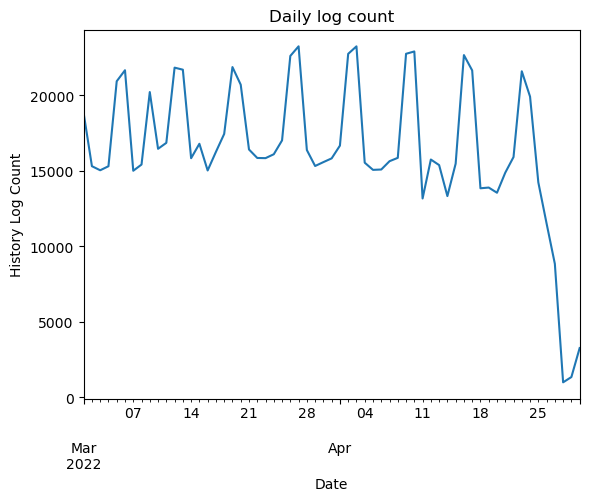

In [6]:
## 날짜 전처리
df_history = df_history.assign(log_dt = pd.to_datetime(df_history.log_time//100, format="%Y%m%d%H%M"))
df_history = df_history.assign(log_date = df_history.log_dt.dt.floor("D"))
df_history = df_history.drop("log_time", axis=1)

df_history.log_dt.dt.floor("D").value_counts().sort_index().plot()
plt.title("Daily log count")
plt.xlabel("Date")
plt.ylabel("History Log Count")
plt.show()

In [7]:
df_history.log_dt.min(), df_history.log_dt.max(), df_history.log_dt.nunique()

(Timestamp('2022-03-01 00:04:00'), Timestamp('2022-04-30 23:59:00'), 75059)

### Split train test

In [8]:
last_date = df_history.log_date.max()

## 1주일 전, 1달 전
last_week = last_date - timedelta(days=7)
last_month = last_date - relativedelta(months=1)

df_train_week = df_history[df_history.log_date <= last_week]
df_test_week = df_history[df_history.log_date > last_week]
df_train_month = df_history[df_history.log_date <= last_month]
df_test_month = df_history[df_history.log_date > last_month]

In [9]:
assert df_test_week.log_date.nunique() == 7
assert df_test_month.log_date.nunique() == 31

In [10]:
## 최근 25개만
df_test_week = df_test_week.sort_values("log_dt")
df_test_month = df_test_month.sort_values("log_dt")

In [11]:
## Train에 있는 profile/album만 test에 두기

print("train에 있는 profile/album만 남기기")

print(f"Test data size:{len(df_test_week):,}(week)")
df_test_week = df_test_week.merge(df_train_week[["profile_id", "album_id"]].drop_duplicates(), on=["profile_id", "album_id"])
print(f"Test data size:{len(df_test_week):,}(week)\n")

print(f"Test data size:{len(df_test_month):,}(month)")
df_test_month = df_test_month.merge(df_train_month[["profile_id", "album_id"]].drop_duplicates(), on=["profile_id", "album_id"])
print(f"Test data size:{len(df_test_month):,}(month)")

train에 있는 profile/album만 남기기
Test data size:60,133(week)
Test data size:28,548(week)

Test data size:472,671(month)
Test data size:157,334(month)


In [12]:
test_answer_week = (
    df_test_week
    .drop_duplicates(["profile_id", "album_id"])
    .groupby("profile_id").head(25)
    .groupby("profile_id").album_id.apply(list)
    .reset_index()
)

test_answer_month = (
    df_test_month
    .drop_duplicates(["profile_id", "album_id"])
    .groupby("profile_id").head(25)
    .groupby("profile_id").album_id.apply(list)
    .reset_index()
)

In [13]:
assert test_answer_week.album_id.apply(len).max()
assert test_answer_month.album_id.apply(len).max()

In [14]:
sample_sumbission_week = test_answer_week.copy()
sample_sumbission_week.album_id = [[]]*len(sample_sumbission_week)

sample_sumbission_month = test_answer_month.copy()
sample_sumbission_month.album_id = [[]]*len(sample_sumbission_month)

### Load

In [15]:
test_answer_week.to_parquet("../../data/test_answer_week.parquet")
test_answer_month.to_parquet("../../data/test_answer_month.parquet")

df_train_week.to_parquet("../../data/train_week.parquet")
df_train_month.to_parquet("../../data/train_month.parquet")

sample_sumbission_week.to_parquet("../../data/sample_sumbission_week.parquet")
sample_sumbission_month.to_parquet("../../data/sample_sumbission_month.parquet")